# CTA data analysis with Gammapy

## Introduction

The focus of this notebook is on demonstrating how to quickly perform a standard analysis of a given target in the sky. The gammapy functions and classes that we'll use won't be explained in detail. Please refer to the other gammapy tutorial notebooks, if you're interested.

At some point there should be a convenience class to make this kind of analysis easier, feedback on how this should be implemented is welcome!

## Setup

As usual, we'll start with some setup ...

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
# Check package versions, if something goes wrong here you won't be able to run the notebook

import numpy as np
import astropy
import regions
import sherpa
import uncertainties

print('numpy:', np.__version__)
print('astropy', astropy.__version__)
print('regions', regions.__version__)
print('sherpa', sherpa.__version__)
print('uncertainties', uncertainties.__version__)

('numpy:', '1.12.0')
('astropy', u'1.3')
('regions', u'0.3.dev410')
('sherpa', 'ciao4.9+1.g1ebebb7')
('uncertainties', '2.4.8.1')


In [3]:
import logging
import numpy as np

import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion

from gammapy.data import DataStore
from gammapy.spectrum import (
    SpectrumExtraction,
    SpectrumFit,
    SpectrumResult,
    models,
    SpectrumEnergyGroupMaker,
    FluxPointEstimator,
    )

from gammapy.image import SkyMask, SkyImage, IACTBasicImageEstimator
from gammapy.background import RingBackgroundEstimator

from gammapy.extern.pathlib import Path
from gammapy.utils.energy import EnergyBounds

In [4]:
# Setup the logger
logging.basicConfig()
log = logging.getLogger('gammapy.spectrum')
log.setLevel(logging.ERROR)

## Load Data

First, we have to load the CTA data exported to fits format (the format is described in detail [here](https://gamma-astro-data-formats.readthedocs.io/en/latest/)).

In [5]:
DATA_DIR = '$GAMMAPY_EXTRA/test_datasets/cta_1dc'


data_store = DataStore.from_dir(DATA_DIR)
data_store.info()
print(data_store.obs_table.colnames)
data_store.obs_table[['OBS_ID', 'RA_PNT', 'DEC_PNT']]


Data store summary info:
name: noname

HDU index table:
BASE_DIR: /home/kingj/Software/gammapy-extra/test_datasets/cta_1dc
Rows: 798
OBS_ID: 362 -- 1197
HDU_TYPE: ['GTI', 'aeff', 'bkg', 'edisp', 'events', 'psf']
HDU_CLASS: ['GTI', 'aeff_2d', 'bkg_3d', 'edisp_2d', 'events', 'psf_3gauss']

Observation table:
Number of observations: 133
['TIME_END', 'DATE_END', 'TIME_OBS', 'ALT_PNT', 'TSTOP', 'TSTART', 'ZEN_PNT', 'LIVETIME', 'OBS_ID', 'DATE_OBS', 'ONTIME', 'DEADC', 'AZ_PNT', 'DEC_PNT', 'RA_PNT', 'EVENTS_FILENME']


OBS_ID,RA_PNT,DEC_PNT
int64,float64,float64
362,265.8704,-32.1729
363,265.8704,-32.1729
364,265.8704,-32.1729
365,265.8704,-32.1729
366,265.8704,-32.1729
367,265.8704,-32.1729
368,265.8704,-32.1729
369,265.8704,-32.1729
370,265.8704,-32.1729


## Select observations

In [6]:
obs_id = [362, 363]
observation_list = data_store.obs_list(obs_id)

## Define inputs

Select the target position and define an ON region for the spectral analysis

In [7]:
target_position = SkyCoord(266.8704, -32.1729, unit='deg', frame='icrs')
on_radius = 0.2 * u.deg

on_region = CircleSkyRegion(center=target_position, radius=on_radius)

In [8]:
# Define reference image centered on the target
xref = target_position.ra.value
yref = target_position.dec.value
size = 5 * u.deg
binsz = 0.02 # degree per pixel
npix = int((size / binsz).value)

ref_image = SkyImage.empty(
    nxpix=npix, nypix=npix, binsz=binsz,
    xref=xref, yref=yref,
    proj='TAN', coordsys='CEL',
)
print(ref_image)

Name: None
Data shape: (250, 250)
Data type: float64
Data unit: None
Data mean: 0.000e+00
WCS type: ['RA---TAN', 'DEC--TAN']



In [9]:
EXCLUSION_FILE = '$GAMMAPY_EXTRA/datasets/exclusion_masks/tevcat_exclusion.fits'
allsky_mask = SkyMask.read(EXCLUSION_FILE)
exclusion = allsky_mask.reproject(ref_image)
exclusion.name = 'exclusion'

## Make maps

Standard analysis products: Counts and Significance images

In [10]:
emin = 100 * u.GeV
emax = 100 * u.TeV

bkg_estimator = RingBackgroundEstimator(0.4 * u.deg, 0.1 * u.deg)
image_estimator = IACTBasicImageEstimator(reference=ref_image, emin=emin, emax=emax,
                                        background_estimator=bkg_estimator,
                                        exclusion_mask=exclusion)

images = image_estimator.run(observation_list)

/home/kingj/Software/gammapy/gammapy/cube/core.py:88: RuntimeWarning: divide by zero encountered in log
  log_data = np.log(self.data.value)
/home/kingj/Software/miniconda3/envs/headversions/lib/python2.7/site-packages/scipy/interpolate/interpolate.py:2382: RuntimeWarning: invalid value encountered in multiply
  values += np.asarray(self.values[edge_indices]) * weight[vslice]
/home/kingj/Software/gammapy/gammapy/background/ring.py:336: RuntimeWarning: divide by zero encountered in true_divide
  result['alpha'] = SkyImage(data=exposure_on.data / result['exposure_off'].data, wcs=wcs)
/home/kingj/Software/gammapy/gammapy/background/ring.py:336: RuntimeWarning: invalid value encountered in true_divide
  result['alpha'] = SkyImage(data=exposure_on.data / result['exposure_off'].data, wcs=wcs)
/home/kingj/Software/gammapy/gammapy/background/ring.py:337: RuntimeWarning: invalid value encountered in multiply
  result['background'] = SkyImage(data=result['alpha'].data * result['off'].data, wcs=w

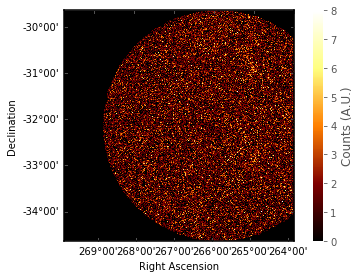

In [11]:
images['counts'].show(add_cbar=True)

/home/kingj/Software/gammapy/gammapy/stats/poisson.py:254: RuntimeWarning: divide by zero encountered in true_divide
  term_b = sqrt(n_on * log(n_on / mu_bkg) - n_on + mu_bkg)


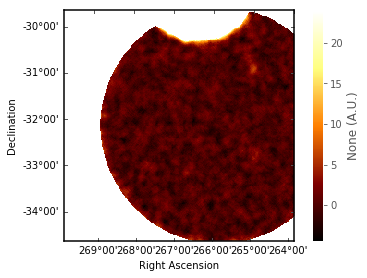

In [12]:
# Significance image
# There is no convenience class for derived images yet, so we have to  compute the significance image ourselves
from astropy.convolution import Tophat2DKernel
kernel = Tophat2DKernel(4)
kernel.normalize('peak')

counts_conv = images['counts'].convolve(kernel.array)
background_conv = images['background'].convolve(kernel.array)

from gammapy.stats import significance
significance_image = SkyImage.empty_like(ref_image)
significance_image.data =  significance(counts_conv.data, background_conv.data)
significance_image.show(add_cbar=True)

# Spectrum

Standard analysis products: Spectrum and flux points

In [13]:
bkg_method = dict(
    method='reflected',
    exclusion=exclusion
)

extract = SpectrumExtraction(target=on_region, obs=observation_list, background=bkg_method)
extract.run()

(<matplotlib.figure.Figure at 0x7f42b2f6ba90>,
 <matplotlib.axes._subplots.WCSAxesSubplot at 0x7f42b13c9250>)

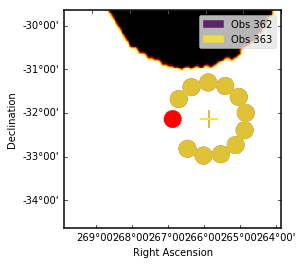

In [14]:
extract.refl.plot()

In [15]:
model = models.PowerLaw(index = 2 * u.Unit(''),
                       amplitude = 1e-11 * u.Unit('cm-2 s-1 TeV-1'),
                       reference = 1 * u.TeV)

fit = SpectrumFit(extract.observations, model)
fit.fit()
fit.est_errors()
print(fit.result[0])

/home/kingj/Software/gammapy/gammapy/stats/fit_statistics.py:161: RuntimeWarning: divide by zero encountered in log
  term2_ = - n_on * np.log(mu_sig + alpha * mu_bkg)
/home/kingj/Software/gammapy/gammapy/stats/fit_statistics.py:166: RuntimeWarning: divide by zero encountered in log
  term3_ = - n_off * np.log(mu_bkg)
/home/kingj/Software/gammapy/gammapy/stats/fit_statistics.py:198: RuntimeWarning: divide by zero encountered in log
  term1 = - n_on * (1 - np.log(n_on))
/home/kingj/Software/gammapy/gammapy/stats/fit_statistics.py:199: RuntimeWarning: divide by zero encountered in log
  term2 = - n_off * (1 - np.log(n_off))
/home/kingj/Software/gammapy/gammapy/spectrum/models.py:441: RuntimeWarning: overflow encountered in power
  upper = np.power((emax / pars['reference'].quantity), val)
/home/kingj/Software/gammapy/gammapy/spectrum/models.py:442: RuntimeWarning: overflow encountered in power
  lower = np.power((emin / pars['reference'].quantity), val)



Fit result info 
--------------- 
Model: PowerLaw
ParameterList
Parameter(name=u'index', value=1.6296499274821477, unit=Unit(dimensionless), min=0, max=None, frozen=False)
Parameter(name=u'amplitude', value=4.371165767319542e-27, unit=Unit("1 / (cm2 s TeV)"), min=0, max=None, frozen=False)
Parameter(name=u'reference', value=1.0, unit=Unit("TeV"), min=None, max=None, frozen=True)

Covariance: [[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]] 

Statistic: 32.812 (wstat)
Fit Range: [  1.00000000e-02   1.00000000e+02] TeV



In [16]:
# Flux points are computed on stacked observation
stacked_obs = extract.observations.stack()
print(stacked_obs)

ebounds = EnergyBounds.equal_log_spacing(1, 40, 4, unit = u.TeV)

seg = SpectrumEnergyGroupMaker(obs=stacked_obs)
seg.compute_range_safe()
seg.compute_groups_fixed(ebounds=ebounds)

fpe = FluxPointEstimator(
    obs=stacked_obs,
    groups=seg.groups,
    model=fit.result[0].model,
)
fpe.compute_points()
fpe.flux_points.table

*** Observation summary report ***
Observation Id: [362-363]
Livetime: 0.950 h
On events: 1408
Off events: 16439
Alpha: 0.091
Bkg events in On region: 1494.45
Excess: -86.45
Excess / Background: -0.06
Gamma rate: -0.02 1 / min
Bkg rate: 0.36 1 / min
Sigma: -2.16
energy range: 0.01 TeV - 100.00 TeV


/home/kingj/Software/gammapy/gammapy/stats/poisson.py:383: RuntimeWarning: divide by zero encountered in double_scalars
  temp = (alpha + 1) / (n_on + n_off)
/home/kingj/Software/gammapy/gammapy/stats/poisson.py:384: RuntimeWarning: divide by zero encountered in log
  l = n_on * log(n_on * temp / alpha)


e_max,e_min,e_ref,dnde_err,dnde
TeV,TeV,TeV,1 / (m2 s TeV),1 / (m2 s TeV)
float64,float64,float64,float64,float64
2.44843674682,1.13646366639,1.6681005372,9.07217798033e-10,1.89868468868e-23
5.99484250319,2.44843674682,3.83118684956,8.40379678245e-11,2.27020982816e-11
14.6779926762,5.99484250319,9.3804186664,1.21642145068e-11,3.48619071924e-12
35.938136638,14.6779926762,22.9673617634,1.5302300179e-12,2.64522520971e-25


(<matplotlib.axes._subplots.AxesSubplot at 0x7f42af593dd0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f42b2f88a50>)

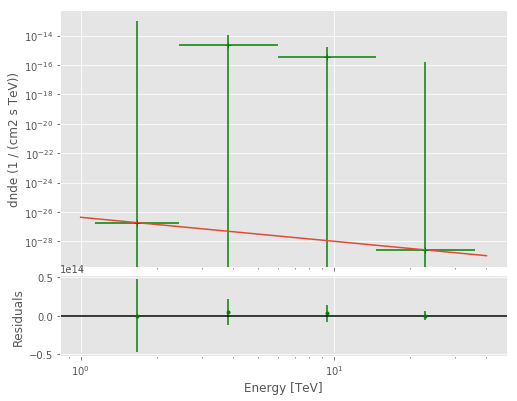

In [17]:
total_result = SpectrumResult(model=fit.result[0].model,
                             points=fpe.flux_points)

total_result.plot(energy_range = [1, 40] * u.TeV,
                 fig_kwargs=dict(figsize=(8,8)),
                 point_kwargs=dict(color='green'))

## What next?

TODO